# EDA (Exploratory Data Analysis)

In this notebook I explore the data visually and try to pick out some insights from the data.

## Notes
### Outliers and Visualisation
Most plots of model loss are truncated since there are a number of massive outliers that make the interesting parts of the data hard to see (esp. when using the ReLU activation with a high learning rate).

### Incomparability of Regression and Classification Task Results
Since the regression tasks and classification tasks use different metrics, it is hard to directly compare the performance of the models accross both tasks. This is due the use of Pearson's R and RMSE in regression, whereas log loss and accuracy are being used for classification. As such, I would believe it best to consider models doing regression separately from models classification.

### Invalidity of Scoring Metric for Regression Tasks
The scoring metric used for evaluating the regression type models was Pearson's Correlation Coefficient (PCC):
![Pearson's Correlation Coefficient](https://wikimedia.org/api/rest_v1/media/math/render/svg/2b9c2079a3ffc1aacd36201ea0a3fb2460dc226f)
Here $x$ would be the target labels and $y$ the predicted labels.

Due to the unfortunate combination of PCC with SGD and binary valued spaces, many of the scores produced for the regression based models are likely erroneous. This is largely due to small batch sizes producing unfortunate combinations of output labels. For example, in the XOR problem if using a batch size of two, one may encounter the pair of target labels 0 and 0 (with inputs of [0, 0] and [1, 1]). The outputs of course have a variance of zero and we get a demonator of zero (see the equation above). 

I thought it was a good idea to add a small value $\epsilon$ to the denominator so if the variance was zero I would not get a divide by zero error, and instead get a value very close to zero. Although, this may have been a bad idea in the end since more *'genuine'* PCC scores very close to zero would be indistinguishable from these erroneous zero PCC scores.

Another problem is that with SGD you process one training pattern at a time. This is problematic when it comes to evaluating the PCC since $\bar{x}=x$ and $\bar{y}=y$, therefore the numerator will equal zero.

Using the $R^2$ (a.k.a. the Coefficient of Determination) does not avoid these issues. So it remains unclear to me what would be a robust scoring metric for regression tasks (robust in the sense that it can handle single samples and zero variance).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
os.getcwd()

'/home/anthony/420/notebooks'

In [3]:
df = pd.read_csv('../scripts/results_summary.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4536 entries, ce2406bc88ceda4e2fde96bf96fdd2d5 to 9591fefef4086cbf060bc6afdcee4eba
Columns: 168 entries, activation_func to val_loss_39
dtypes: bool(1), float64(163), int64(1), object(3)
memory usage: 5.8+ MB


In [35]:
# Some useful masks
using_relu = df['activation_func'] == 'LeakyReLU'
using_sigmoid = df['activation_func'] == 'Sigmoid'

using_sgd = df['batch_size'] == 1
using_minibatch_sgd = df['batch_size'] > 1
using_batch_sgd = df['batch_size'] == -1  # -1 was the special value used to indicate batch sgd in experiment code.

using_regression = df['clf_type'] == 'MLPRegressor'
using_classification = df['clf_type'] == 'MLPClassifier'

no_shuffling = df['shuffle_batches'] == False
shuffles_batch = df['shuffle_batches'] == True

In [5]:
# Gather groups of column names
train_loss_cols = df.filter(regex='train_loss_\d{2}').columns.values
train_scores_cols = df.filter(regex='train_scores_\d{2}').columns.values

val_loss_cols = df.filter(regex='val_loss_\d{2}').columns.values
val_scores_cols = df.filter(regex='val_scores_\d{2}').columns.values

In [6]:
datasets = df['dataset'].unique()

In [31]:
def plot(df, thresholds=(10, -1, 10, -1)):
    """Plot the train loss, train scores, validation loss, and validation scores of a masked dataframe.
    
    :param df: A dataframe that is masked for at least dataset.
    :param thresholds: A 4-tuple of threshold that the [train loss/train scores/validation loss/validation scores]
        must be [lower/higher/lower/higher] than to be plotted, respectively.
    """
    assert len(df['dataset'].unique()) == 1, 'You can only plot one dataset at a time!'
    
    t = thresholds
    
    # Data Wrangling    
    stacked_train_loss = pd.Series(df[df[train_loss_cols] < t[0]][train_loss_cols].values.ravel())    
    
    stacked_train_scores = pd.Series(df[df[train_scores_cols] > t[1]][train_scores_cols].values.ravel()) 
    
    stacked_val_loss = pd.Series(df[df[val_loss_cols] < t[2]][val_loss_cols].values.ravel()) 
    
    stacked_val_scores = pd.Series(df[df[val_scores_cols] > t[3]][val_scores_cols].values.ravel())
    
    # Plotting
    if len(stacked_val_loss.dropna()) > 0 or len(stacked_val_scores.dropna()) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(8, 8))
        axes = axes.ravel()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    
    stacked_train_loss.hist(bins=100, ax=axes[0])
    axes[0].set_title('Train Loss')
    
    stacked_train_scores.hist(bins=100, ax=axes[1])
    axes[1].set_title('Train Scores')
    
    if len(stacked_val_loss.dropna()) > 0:
        stacked_val_loss.hist(bins=100, ax=axes[2])
        axes[2].set_title('Validation Loss')
    
    if len(stacked_val_scores.dropna()) > 0:
        stacked_val_scores.hist(bins=100, ax=axes[3])
        axes[3].set_title('Validation Scores')
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Plot for the Dataset %s' % df.iloc[0]['dataset'])

Metrics for Regression Tasks by Dataset


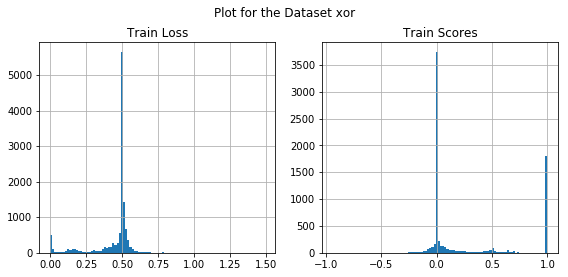

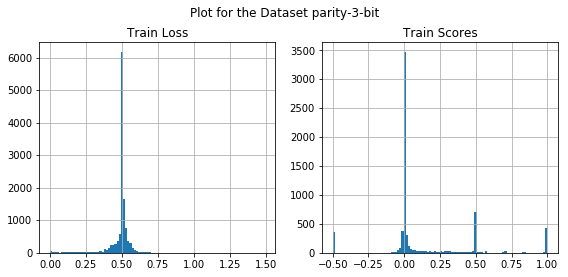

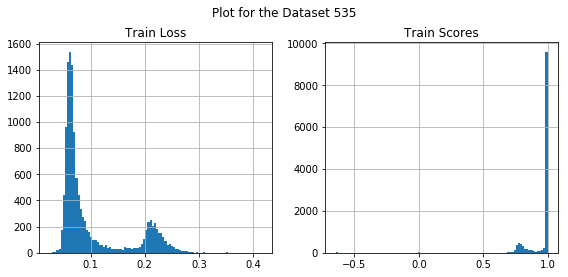

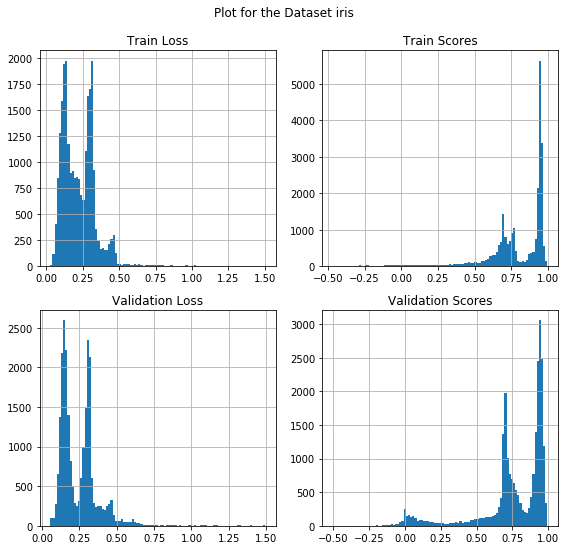

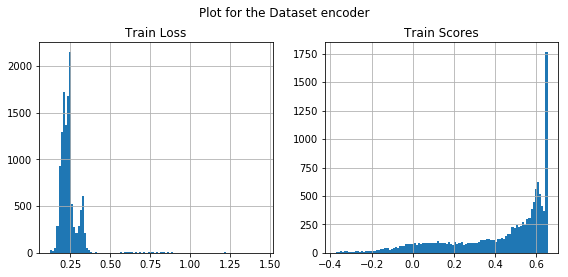

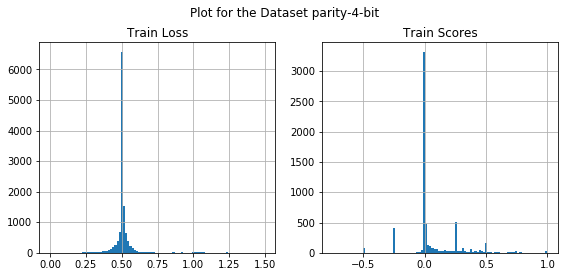

In [37]:
print('Metrics for Regression Tasks by Dataset')

for dataset in datasets:
    plot(df[using_regression & (df['dataset'] == dataset)], thresholds=(1.5, -1, 1.5, -1))

Metrics for Regression Tasks Not Using ReLU by Dataset


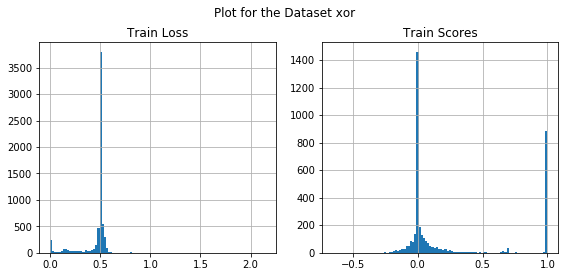

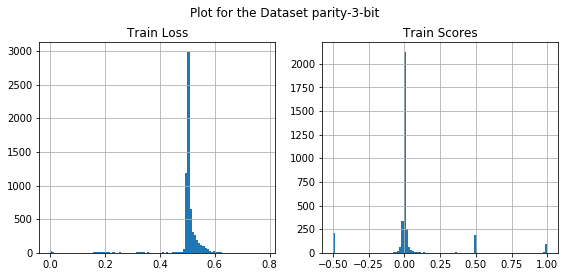

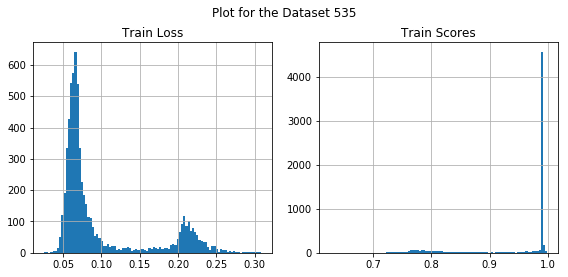

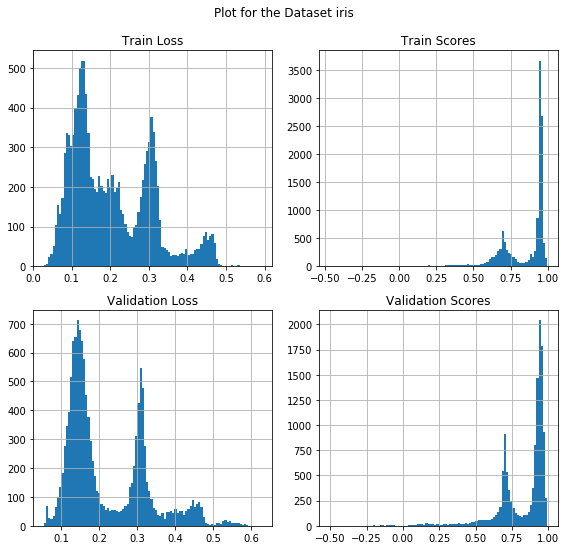

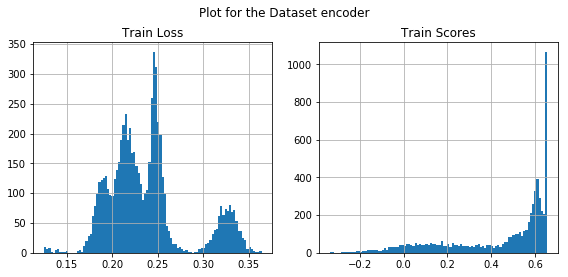

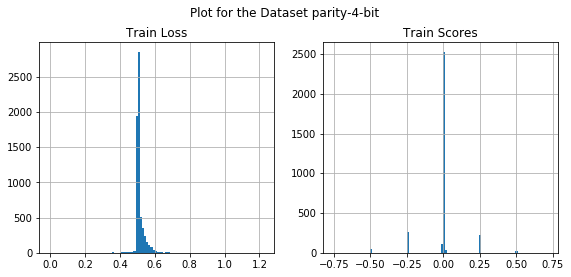

In [32]:
print('Metrics for Regression Tasks Not Using ReLU by Dataset')

for dataset in datasets:
    plot(df[~using_relu & using_regression & (df['dataset'] == dataset)], thresholds=(2.5, -1, 2.5, -1))

Metrics for Classification Tasks by Dataset


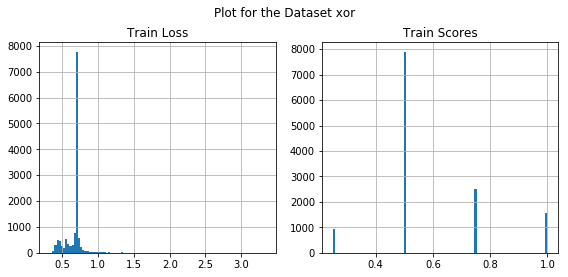

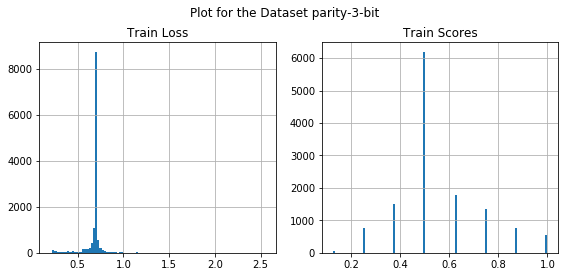

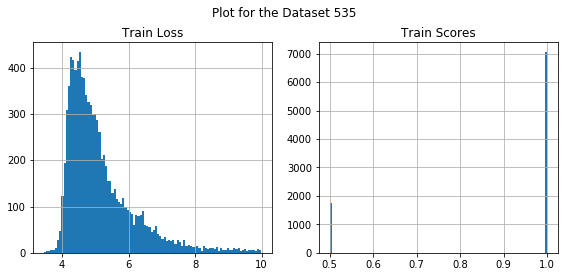

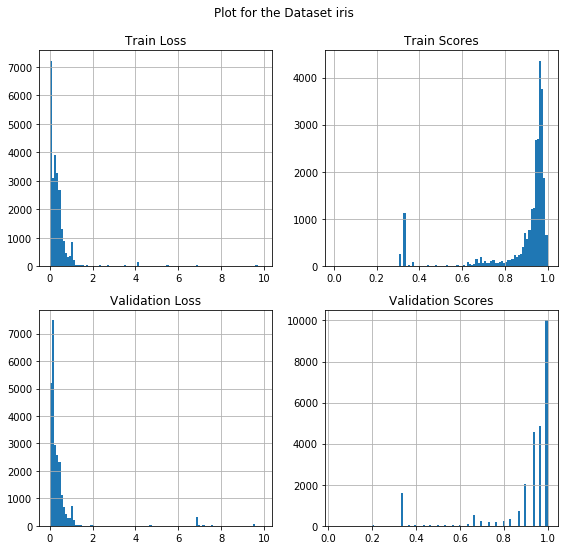

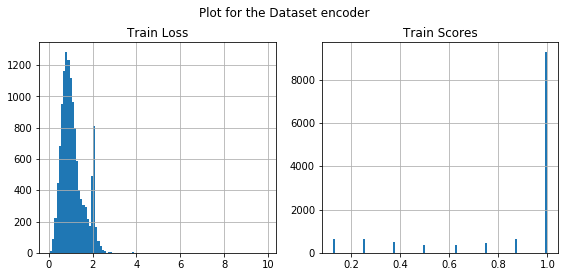

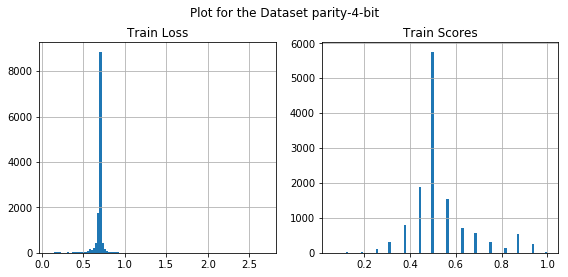

In [30]:
print('Metrics for Classification Tasks by Dataset')

for dataset in datasets:
    plot(df[using_classification & (df['dataset'] == dataset)], thresholds=(10, 0, 10, 0))